# EcoFOCIpy ADCP Tidal Verification - 22BSP-5A

use utide (t_tide) to plot "the M2 tidal component" against a reference deployment (2018)

Todo: Build reference datasset into EcoFOCIpy for M2, M4, M5, M8

In [16]:
from utide import solve, reconstruct
import matplotlib.pyplot as plt

import xarray as xa
import pandas as pd
import numpy as np

In [17]:
xdf = xa.load_dataset('/Users/bell/ecoraid/2019/Moorings/19bsp5a/final_data_cf/19bsp5a_velein_0057m.nc')

In [18]:
kw = dict(lat=xdf.latitude.values, constit='auto', trend=False, method='ols', Rayleigh_min=0.95,)

#average in depth
u = xdf.u_curr_comp.isel({'latitude':0,'longitude':0}).mean(dim='depth')
v = xdf.v_curr_comp.isel({'latitude':0,'longitude':0}).mean(dim='depth')

coef = solve(xdf.time.values, u.values, v.values, **kw)

solve: matrix prep ... solution ... done.


In [19]:
df = pd.DataFrame(index=coef['name'],
             data=np.array([coef['Lsmaj'],coef['Lsmin'],coef['g'],coef['theta']]).T,
            columns=['Lsmaj','Lsmin','g','theta'])

In [20]:
df.loc[['M2','K1']]

,Lsmaj,Lsmin,g,theta
M2,22.133333,-14.058883,120.339464,29.336937
K1,8.133126,-7.075923,160.525607,124.561117


In [21]:
MM = df.loc[['M2']]
SEMA, SEMI = MM['Lsmaj'], MM['Lsmin']
PHA, INC = MM['g'], MM['theta']
ECC = SEMI / SEMA 

In [22]:
"""
Ellipse plot subfunction.

Converted to Python by Pierre Cazenave, October 2012.

"""

def plot_ellipse(SEMA, ECC, INC, PHA, color=False):
    i = 1j

    SEMI = SEMA * ECC
    Wp = (1 + ECC) / 2 * SEMA
    Wm = (1 - ECC) / 2 * SEMA
    THETAp = INC - PHA
    THETAm = INC + PHA

    # Convert degrees into radians
    THETAp = THETAp / 180 * np.pi
    THETAm = THETAm / 180 * np.pi
    INC = INC / 180 * np.pi
    PHA = PHA / 180 * np.pi

    # Calculate wp and wm.
    wp = Wp * np.exp(i * THETAp)
    wm = Wm * np.exp(i * THETAm)

    dot = np.pi / 36
    ot = np.arange(0, 2 * np.pi, dot)
    a = wp * np.exp(i * ot)
    b = wm * np.exp(-i * ot)
    w = a + b

    wmax = SEMA * np.exp(i * INC)
    wmin = SEMI * np.exp(i * (INC + np.pi / 2))

    plt.plot(np.real(w), np.imag(w))
    plt.axis('equal')
    # plt.hold('on')
    plt.plot([0, np.real(wmax)[0]], [0, np.imag(wmax)[0]], 'm')
    plt.plot([0, np.real(wmin)[0]], [0, np.imag(wmin)[0]], 'm')
    plt.xlabel('u')
    plt.ylabel('v')
    if color:
        plt.plot(np.real(a), np.imag(a), 'k')
        plt.plot(np.real(b), np.imag(b), 'k')
        plt.plot(np.real(w), np.imag(w), 'k')
    else:
        plt.plot(np.real(a), np.imag(a), 'r')
        plt.plot(np.real(b), np.imag(b), 'g')
    plt.plot([0, np.real(a[0])], [0, np.imag(a[0])], 'ro')
    plt.plot([0, np.real(b[0])], [0, np.imag(b[0])], 'go')
    plt.plot([0, np.real(w[0])], [0, np.imag(w[0])], 'bo')
    plt.plot(np.real(a[0]), np.imag(a[0]), 'ro')
    plt.plot(np.real(b[0]), np.imag(b[0]), 'go')
    plt.plot(np.real(w[0]), np.imag(w[0]), 'bo')
    plt.plot(np.real([a[0], a[0]+b[0]]), np.imag([a[0], a[0]+b[0]]), linestyle='--', color='g')
    plt.plot(np.real([b[0], a[0]+b[0]]), np.imag([b[0], a[0]+b[0]]), linestyle='--', color='r')

    for n in range(len(ot)):
        # plt.hold('on')
        plt.plot(np.real(a[n]), np.imag(a[n]), 'ro')
        plt.plot(np.real(b[n]), np.imag(b[n]), 'go')
        plt.plot(np.real(w[n]), np.imag(w[n]), 'bo')

    # plt.hold('off')    
    return plt

<module 'matplotlib.pyplot' from '/Users/bell/mambaforge/envs/py311/lib/python3.11/site-packages/matplotlib/pyplot.py'>

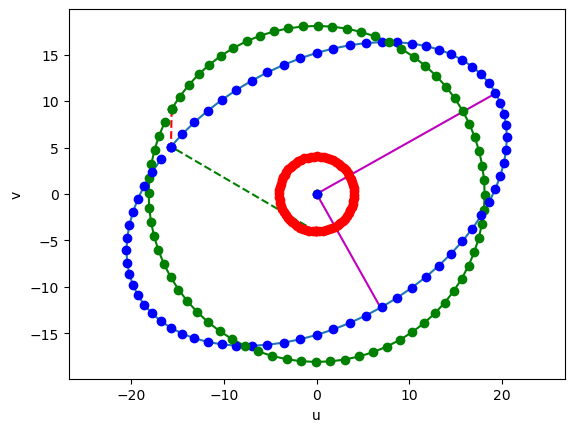

In [23]:
plot_ellipse(SEMA.values, ECC.values, INC.values, PHA.values)

In [25]:
#refernce tidal loop - 2018

bxdf = xa.load_dataset('/Users/bell/ecoraid/2018/Moorings/18bsp5a/erddap/final_data/18bsp5a_wcp_vel.cf.nc')
bxdf =bxdf.where(bxdf.u_1205 <=100000,np.nan)

kw = dict(lat=xdf.latitude.values, constit='auto', trend=False, method='ols', Rayleigh_min=0.95,)

try:
    u = bxdf.u_curr_comp.isel({'latitude':0,'longitude':0}).mean(dim='depth')
    v = bxdf.v_curr_comp.isel({'latitude':0,'longitude':0}).mean(dim='depth')
except:
    u = bxdf.u_1205.isel({'lat':0,'lon':0}).mean(dim='depth')
    v = bxdf.v_1206.isel({'lat':0,'lon':0}).mean(dim='depth')   
coef = solve(bxdf.time.values, u.values, v.values, **kw)

bdf = pd.DataFrame(index=coef['name'],
             data=np.array([coef['Lsmaj'],coef['Lsmin'],coef['g'],coef['theta']]).T,
            columns=['Lsmaj','Lsmin','g','theta'])

bMM = bdf.loc[['M2']]
bSEMA, bSEMI = bMM['Lsmaj'], bMM['Lsmin']
bPHA, bINC = bMM['g'], bMM['theta']
bECC = bSEMI / bSEMA 

solve: matrix prep ... solution ... done.


<module 'matplotlib.pyplot' from '/Users/bell/mambaforge/envs/py311/lib/python3.11/site-packages/matplotlib/pyplot.py'>

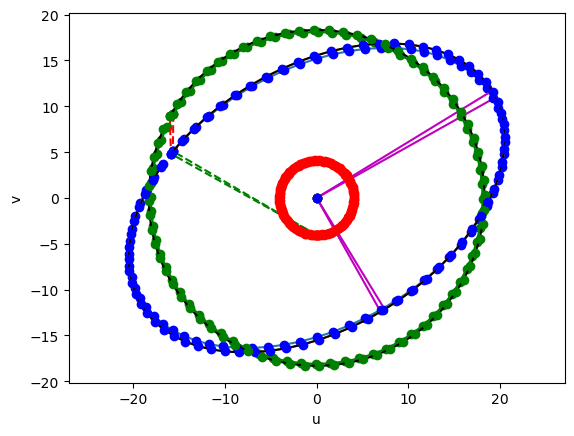

In [26]:
plot_ellipse(SEMA.values, ECC.values, INC.values, PHA.values)
plot_ellipse(bSEMA.values, bECC.values, bINC.values, bPHA.values, 'k')